In [208]:
import torch
import plotly.offline as py
import plotly.graph_objs as go
import pandas as pd
import numpy as np
py.init_notebook_mode(connected=True)

In [209]:
data_origin = pd.read_csv('data_to_learn.tradition.csv')

In [210]:
data_origin

,nGB,nRandom,BindingEnergy,id,pe,pos_1,pos_2,pos_3,cna,centro_fnn,...,f_2,f_3,stress_1,stress_2,stress_3,stress_4,stress_5,stress_6,voronoi_1,voronoi_2
0,1,1,0.001107,57648,-8.90781,1.87391,56.636000,-8.063477,3.0,0.000603,...,-6.170730e-06,4.010470e-07,53757.70,20902.40,-172341.00,-91705.800,147018.000,-88657.100,15.8657,14.0
1,1,2,0.003313,51853,-8.89995,48.81900,33.777100,19.472519,3.0,0.000002,...,6.832920e-06,-4.615460e-05,11925.80,12800.00,32683.10,1637.530,-1137.930,11929.800,15.8617,14.0
2,1,3,0.000967,60668,-8.89760,7.67237,46.942100,10.695526,3.0,0.000172,...,3.605700e-05,-9.934411e-06,-24029.70,95367.50,-78300.20,37314.700,-20587.300,881.814,15.8497,14.0
3,1,4,-0.008195,10034,-8.92250,16.13360,0.015369,-5.868485,3.0,0.010504,...,3.619720e-05,6.110110e-05,296787.00,-204639.00,5749.62,-266990.000,375494.000,-12452.800,15.9133,14.0
4,1,5,0.005728,21910,-8.90006,20.85490,18.011200,-18.592484,3.0,0.000004,...,1.762520e-05,2.931540e-05,12739.10,9464.20,34735.10,-482.103,316.154,6355.640,15.8622,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,28,996,0.046718,19191,-8.89964,27.44370,4.495880,16.873780,3.0,0.000038,...,2.631370e-07,8.834910e-07,-70890.40,10565.10,-152070.00,-7912.440,73065.900,71541.400,15.8325,14.0
27996,28,997,0.059260,102815,-8.89999,59.41920,31.363500,19.406769,3.0,0.000016,...,-8.317720e-06,-1.025390e-06,18403.00,-16030.50,65331.30,7037.430,28804.400,37173.900,15.8630,14.0
27997,28,998,0.013184,65331,-8.89274,10.83950,22.378200,-7.415222,3.0,0.000790,...,-9.931500e-06,-3.821100e-06,194994.00,-8076.33,230004.00,-13426.000,117730.000,-56272.300,15.8853,14.0
27998,28,999,0.045753,25889,-8.89987,60.96050,6.746390,18.986786,3.0,0.000004,...,-6.701260e-06,8.861960e-06,-2274.76,5433.21,15938.10,-2996.940,-35634.900,36273.100,15.8574,14.0


## three layer neural network

In [224]:
#random shuffle
data = data_origin.sample(frac=1, random_state=1)
#split data
Y_all = data['BindingEnergy'].to_numpy()
Y_train = Y_all[0:int(len(data)*.7)]
Y_temp = Y_all[int(len(data)*.7):]
Y_cos = Y_temp[:int(len(Y_temp)*.5)]
Y_test = Y_temp[int(len(Y_temp)*.5):]

X_all = data.iloc[:, 4:].to_numpy()
X_train = X_all[:int(len(X_all)*.7)]

#normalization
X_mean = np.mean(X_train, axis = 0)
X_std = np.std(X_train, axis = 0)

X_train = (X_train - X_mean) / X_std

X_temp = X_all[int(len(X_all)*.7):]
X_temp = (X_temp - X_mean) / X_std
X_cos = X_temp[:int(len(X_temp)*.5)]
X_test = X_temp[int(len(X_temp)*.5):]   

In [225]:
(N, D_in) = X_train.shape
H = 200
D_out = 1

X_train = torch.from_numpy(X_train)
X_train = X_train.float()
y = torch.from_numpy(Y_train)
y = y.float()
y = y.view(y.shape[0],1)
model1 = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 25),
    torch.nn.ReLU(),
    torch.nn.Linear(25, D_out)
)

loss_fn1 = torch.nn.MSELoss(reduction='sum')
learning_rate = 2e-5
optimizer1 = torch.optim.SGD(model1.parameters(), lr = learning_rate, momentum = 0.9, weight_decay = 0.3)#0.2

In [226]:
def WMSELoss(yhat,y):
    return torch.sum(((yhat-y) / y)**2)

In [227]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1.to(device)
X_train = X_train.to(device)
y = y.to(device)

In [228]:
for t in range(100001):
    y_pred = model1(X_train)
    
    loss = loss_fn1(y_pred, y)
    if t%500 == 0:
        print(t, loss.item())
    
    optimizer1.zero_grad()
    
    loss.backward()
    
    optimizer1.step()

0 1866.6845703125
500 33.2767219543457
1000 17.107494354248047
1500 13.564823150634766
2000 9.427776336669922
2500 8.159674644470215
3000 7.83597469329834
3500 7.10745906829834
4000 6.671807289123535
4500 11.353620529174805
5000 5.939250946044922
5500 7.290150165557861
6000 5.793497562408447
6500 6.543400287628174
7000 7.430038928985596
7500 5.431957721710205
8000 5.068647384643555
8500 5.031833648681641
9000 5.363429546356201
9500 13.740053176879883
10000 6.2090935707092285
10500 9.866728782653809
11000 6.815493583679199
11500 4.59999418258667
12000 5.614013671875
12500 5.485848426818848
13000 5.179502010345459
13500 4.228564262390137
14000 7.048360347747803
14500 4.238738536834717
15000 5.036001205444336
15500 5.307390213012695
16000 4.614372730255127
16500 6.185239791870117
17000 4.5240607261657715
17500 4.464043140411377
18000 4.015260219573975
18500 3.969270706176758
19000 5.808167457580566
19500 3.6968369483947754
20000 3.7132070064544678
20500 4.10538911819458
21000 3.9821584224

In [229]:
X_cos = torch.from_numpy(X_cos)
X_cos = X_cos.float()
X_cos = X_cos.to(device)
Y_cos_pred = model1(X_cos)
Y_cos_pred = Y_cos_pred.detach().cpu()
Y_cos_pred = Y_cos_pred.numpy()
Y_cos_pred = Y_cos_pred.squeeze()
Y_cos = Y_cos.squeeze()
Y_mean = np.mean(Y_cos)
SS_tot = np.sum(np.power(Y_cos - Y_mean, 2))
SS_res = np.sum(np.power(Y_cos_pred - Y_cos, 2))
R_squared = 1-SS_res/SS_tot

In [230]:
y_train_pred = y_pred.detach().cpu().numpy()


In [231]:
y_train_pred.shape

(19600, 1)

In [232]:
Y_train.shape

(19600,)

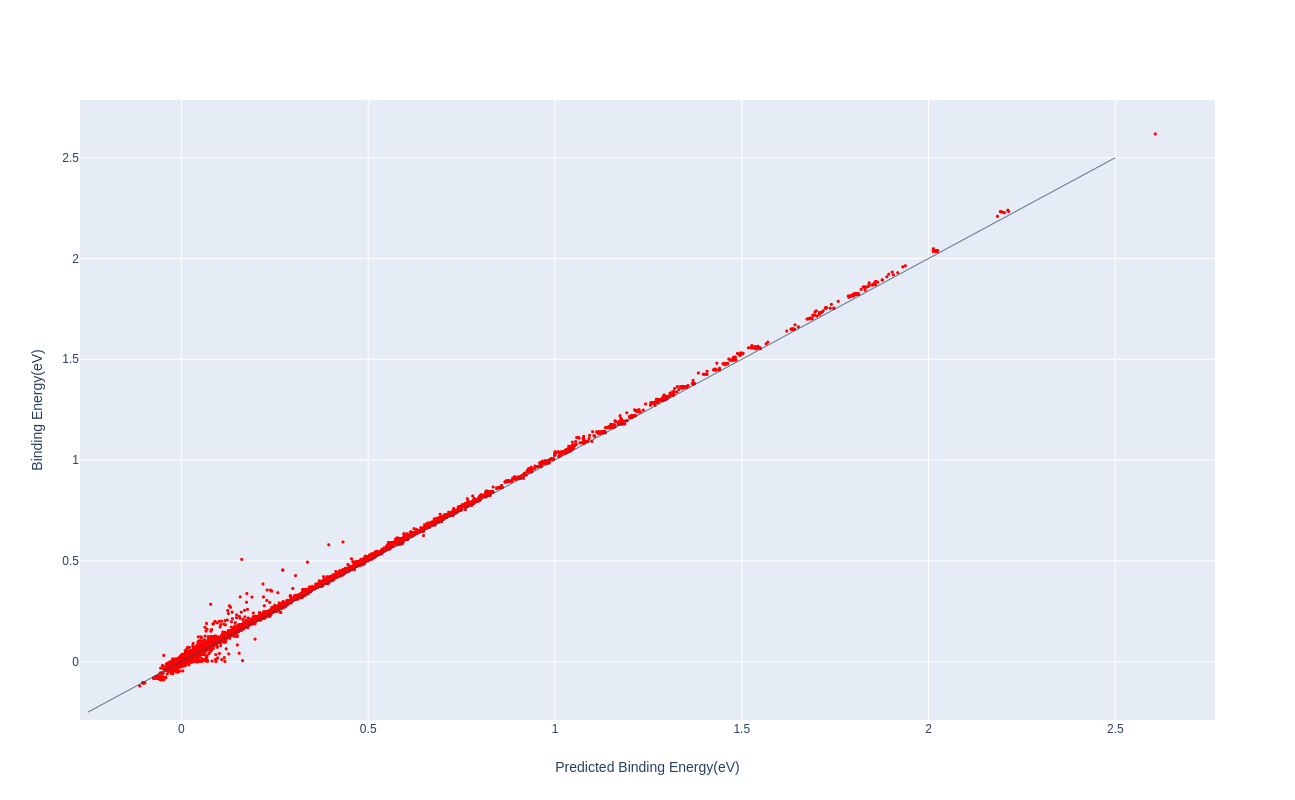

In [233]:
#draw correlation
main = go.Scatter(x = y_train_pred.squeeze(), 
          y = Y_train, 
          marker={'color':'red', 'symbol':'circle','size':3}, 
          mode='markers'
         )

data = [main]

layout = go.Layout(autosize = False, 
           height = 800,
           width = 800, 
           xaxis={'title':"Predicted Binding Energy(eV)", 'zeroline':False},
           yaxis = {'title':'Binding Energy(eV)', 'zeroline':False},
           annotations = [
                   dict(
                   x = 0,
                   y = 1,
                   xref = 'paper',
                   yref = 'paper',
                   text = '$R^2= %4.2f$'%(R_squared),
                   showarrow = False,
                   font = dict(size = 12)
                   )
               ],
           shapes =[{'type':'line', 
                            'x0':-0.25,
                            'x1':2.5,
                            'y0':-0.25,
                            'y1':2.5,
                            'line':{'width':0.7}
                    }],
          )
plot = py.iplot(go.Figure(data = data, layout = layout))

In [234]:
Y_cos_pred

array([0.00664006, 0.00434965, 0.00809105, ..., 0.00371698, 0.33451986,
       0.5017478 ], dtype=float32)

In [235]:
Y_cos

array([0.00218271, 0.00069144, 0.00246606, ..., 0.00102566, 0.34812272,
       0.48822666])

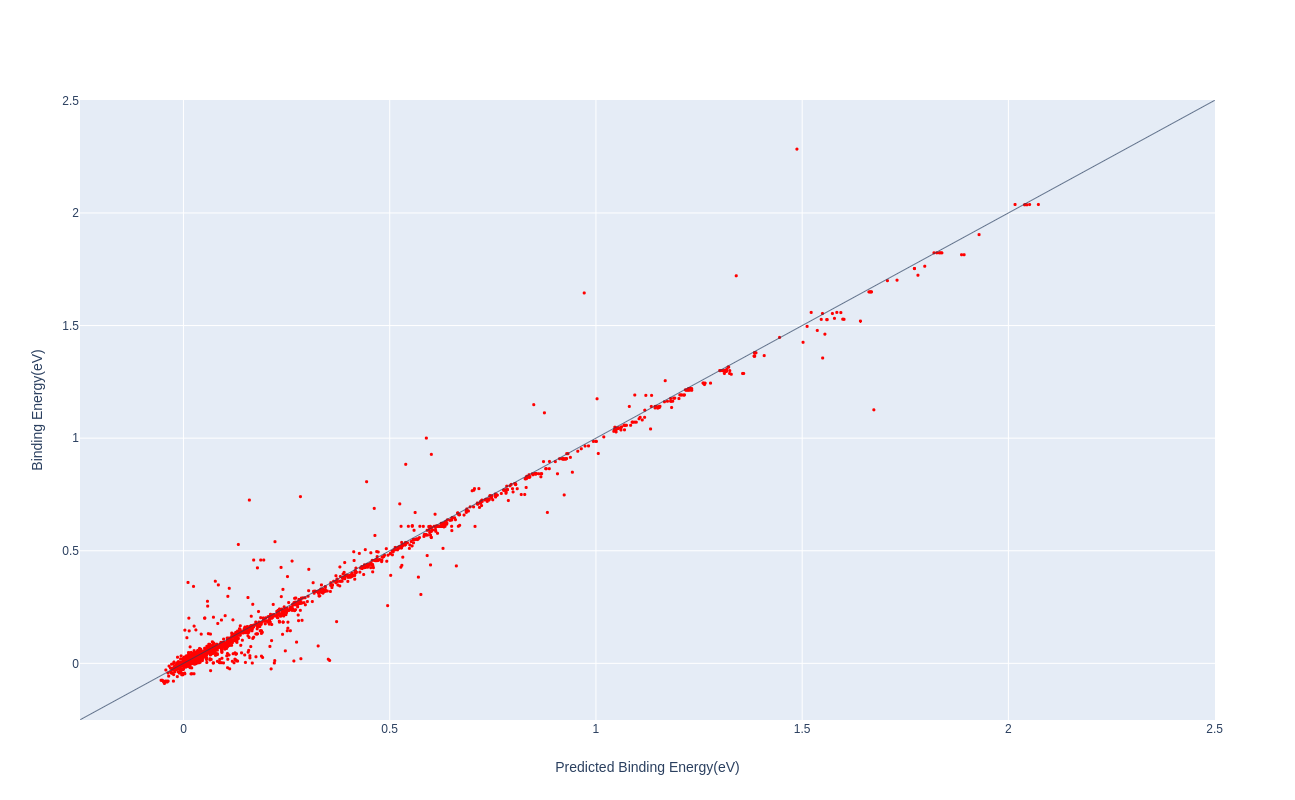

In [236]:
#draw correlation
main = go.Scatter(x = Y_cos_pred, 
          y = Y_cos, 
          marker={'color':'red', 'symbol':'circle','size':3}, 
          mode='markers'
         )

data = [main]

layout = go.Layout(autosize = False, 
           height = 800,
           width = 800, 
           xaxis={'title':"Predicted Binding Energy(eV)", 'zeroline':False},
           yaxis = {'title':'Binding Energy(eV)', 'zeroline':False},
           annotations = [
                   dict(
                   x = 0,
                   y = 1,
                   xref = 'paper',
                   yref = 'paper',
                   text = '$R^2= %4.2f$'%(R_squared),
                   showarrow = False,
                   font = dict(size = 12)
                   )
               ],
           shapes =[{'type':'line', 
                            'x0':-0.25,
                            'x1':2.5,
                            'y0':-0.25,
                            'y1':2.5,
                            'line':{'width':0.7}
                    }],
          )
plot = py.iplot(go.Figure(data = data, layout = layout))